# General Instructions to students:

1. There are 5 types of cells in this notebook. The cell type will be indicated within the cell.
    1. Markdown cells with problem written in it. (DO NOT TOUCH THESE CELLS) (**Cell type: TextRead**)
    2. Python cells with setup code for further evaluations. (DO NOT TOUCH THESE CELLS) (**Cell type: CodeRead**)
    3. Python code cells with some template code or empty cell. (FILL CODE IN THESE CELLS BASED ON INSTRUCTIONS IN CURRENT AND PREVIOUS CELLS) (**Cell type: CodeWrite**)
    4. Markdown cells where a written reasoning or conclusion is expected. (WRITE SENTENCES IN THESE CELLS) (**Cell type: TextWrite**)
    5. Temporary code cells for convenience and TAs. (YOU MAY DO WHAT YOU WILL WITH THESE CELLS, TAs WILL REPLACE WHATEVER YOU WRITE HERE WITH OFFICIAL EVALUATION CODE) (**Cell type: Convenience**)
    
2. You are not allowed to insert new cells in the submitted notebook.

3. You are not allowed to import any extra packages.

4. The code is to be written in Python 3.6 syntax. Latest versions of other packages maybe assumed.

5. In CodeWrite Cells, the only outputs to be given are plots asked in the question. Nothing else to be output/print. 

6. If TextWrite cells ask you to give accuracy/error/other numbers you can print them on the code cells, but remove the print statements before submitting.

7. The convenience code can be used to check the expected syntax of the functions. At a minimum, your entire notebook must run with "run all" with the convenience cells as it is. Any runtime failures on the submitted notebook as it is will get zero marks.

8. All code must be written by yourself. Copying from other students/material on the web is strictly prohibited. Any violations will result in zero marks.

9. All datasets will be given as .npz files, and will contain data in 4 numpy arrays :"X_train, Y_train, X_test, Y_test". In that order. The meaning of the 4 arrays can be easily inferred from their names.

10. All plots must be labelled properly, all tables must have rows and columns named properly.

11. Before subbmission ensure that you submit with the outputs (do not clear the outputs), so that when evaluating we can run selectively.

12. Before submission ensure that the path for the folder containing the data is "../../Data/" 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import matplotlib as mpl
import pandas as pd

# 1. Logistic Regression 

Write code for doing logistic regression below. Also write code for choosing best hyperparameters for each kernel type (use a part of training set as validation set). 

The range of hyperparameters is typically chosen on a log scale e.g. 1e-4, 1e-3, 1e-2... 1e3.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters. 

For each given hyperparameter setting (kernel and regularisation) you will have to do some exploring to find the right learning rate to use in gradient descent. The optimisation learning rate is not a model hyperparameter and hence can be chosen based on just the training set. i.e. choose the learning rate for which the training loss decreases the most.

For the synthetic classification datasets (dataset_A and dataset_B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.


In [8]:
# CodeWrite 
#Write logistic regression code from scratch. Use gradient descent.
# Only write functions here

def linear_kernel_value(u, v):
    return np.dot(u, v)

def poly_kernel_value(u, v, d):
    return (1+np.dot(u, v))**d

def rbf_kernel_value(u, v, gamma):
    return np.exp(-1*gamma*(np.linalg.norm(np.subtract(u, v))**2))

def get_kernel_value(u, v, kernel, kernel_param):
    if kernel == 'linear':
        return linear_kernel_value(u, v)
    elif kernel == 'rbf':
        return rbf_kernel_value(u, v, kernel_param)
    elif kernel == 'poly':
        return poly_kernel_value(u, v, kernel_param)

def get_kernel_matrix(X, kernel, kernel_param):
    """
    Arguments:
    X : (n,d) shape numpy array
    kernel = 'linear' or 'rbf' or 'poly'
    reg_param = lambda, for regularized logistic regression
    kernel_param = gamma for rbf kernel or degree of poly kernel

    Returns the kernel matrix :
    K: (n,n) shape numpy array
    """
    n = X.shape[0]
    K = np.zeros(shape=(n,n))
    for i in range(n):
        for j in range(n):
            K[i, j] = get_kernel_value(X[i], X[j], kernel, kernel_param)
    return K

def compute_gradient(K, Y, reg_param, alpha):
    grad = reg_param * np.matmul(K, alpha)
    for i in range(Y.shape[0]):
        grad = np.add(grad, (-1*Y[i]/(1+np.exp(Y[i]*np.dot(alpha, K[:, i]))))*K[:, i])
    return grad

def train_pred_logistic_regression(X, Y, kernel='linear', reg_param=0., 
                                   kernel_param=1., num_iter_gd=100):
    """
    Arguments:
    X : (n,d) shape numpy array
    Y : (n,)  shape numpy array
    X_test : (m,d) shape numpy array
    kernel = 'linear' or 'rbf' or 'poly' 
    reg_param = $\ lambda$
    num_iter_gd = number of GD iterations.

    Returns the result of kernel logistic regression :
    alpha: Vector of solutions for the dual. Numpy array of shape (n,)

    Primal problem:
    $ \ min_w  \ sum_{i=1}^n \ log(1+\exp(-y_i* \ w^\ top \ phi(\ x_i)))  + \ frac{\ lambda}{2} ||\ w||^2 $

    the dual of which is

    $ \ min_alpha \ sum_{i=1}^n \ log(1+\exp(-y_i* \ alpha^\ top K_{:,i} ))  + \ frac{\ lambda}{2} \ alpha^\ top K \ alpha $
    where $\ phi$ is the feature got by the kernel.

    Where K is the nxn kernel matrix computed on the training data.

    The kernel is defined by the kernel_param:
    If kernel=linear: K(\ u,\ v) = \ u^\ top \ v  
    If kernel=poly:  K(\ u,\ v) = (1+\ u^\ top \ v)^(kernel_param)
    If kernel=rbf:  K(\ u,\ v) = \ exp(-kernel_param*||\ u-\ v||^2)
    """
    n = Y.shape[0]
    K = get_kernel_matrix(X, kernel, kernel_param)
    # Initialization
    alpha = np.zeros(shape=(n,))
    # Experiment? Just try some different values and minimize training loss
    learning_rate = 0.1 
    for iteration in range(num_iter_gd):
        alpha = np.subtract(alpha, learning_rate * compute_gradient(K, Y, reg_param, alpha))
    return alpha

def get_pred(alpha, train_X, test_x, kernel, kernel_param):
    pred_sum = 0
    for i in range(train_X.shape[0]):
        pred_sum = pred_sum + alpha[i] * get_kernel_value(train_X[i], test_x, kernel, kernel_param)
    if pred_sum < 0:
        return -1
    return 1

def test_pred(alpha, train_X, train_Y, test_X, kernel, kernel_param):
    """
    Return the predictions on test_X using the learnt alphas
    """
    m = test_X.shape[0]
    pred = np.zeros(shape=m)
    for i in range(m):
        pred[i] = get_pred(alpha, train_X, test_X[i], kernel, kernel_param)
    return pred

    



In [9]:
# CodeWrite : Use the functions above to do validation to get best hyperparameters 
# (i.e. kernel_param and regularisation_param).
# Also, get the numbers you report below. 

def accuracy_score(Y_true, Y_pred):
    return np.size(Y_true[Y_true==Y_pred])/np.size(Y_true)

def cross_validate(X, Y, kernel):
    """
    Arguments:
    X : Training data X_train, numpy array of shape (n,d)
    Y : Training labels Y_train, numpy array of shape (n,)
    kernel = choice of kernel, 'linear', 'rbf' or 'poly'

    Returns a tuple (best_reg_param, best_kernel_param), choosing the best hyperparameters by performing cross-validation
    """
    n = X.shape[0]
    # X_train = np.append(X[int(0.05*n):int(0.45*n)], X[int(0.55*n):int(0.95*n)], axis=0)
    # X_val = np.append(X[:int(0.05*n)], np.append(X[int(0.45*n):int(0.55*n)], X[int(0.95*n):], axis=0), axis=0)
    # Y_train = np.append(Y[int(0.05*n):int(0.45*n)], Y[int(0.55*n):int(0.95*n)], axis=0)
    # Y_val = np.append(Y[:int(0.05*n)], np.append(Y[int(0.45*n):int(0.55*n)], Y[int(0.95*n):], axis=0), axis=0)
    X_train = X[:int(0.2*n)]
    X_val = X[int(0.2*n):]
    Y_train = Y[:int(0.2*n)]
    Y_val = Y[int(0.2*n):]

    # Check kernel type and set up list of kernel_params accordingly
    # Also set up list of lambdas
    powers_10 = [1e-4, 1e-2, 1, 1e2, 1e4]
    powers_2 = [1, 2, 4, 8, 16]
    reg_params = np.array(powers_10)
    kernel_params = np.array([0])
    if kernel == 'rbf':
        kernel_params = np.array(powers_10)
    elif kernel == 'poly':
        kernel_params = np.array(powers_2)
    accuracies = np.zeros(shape=(np.size(reg_params), np.size(kernel_params)))
    for i,reg_param in enumerate(reg_params):
        for j,kernel_param in enumerate(kernel_params):
            alpha = train_pred_logistic_regression(X_train, Y_train, kernel, reg_param, kernel_param)
            accuracies[i, j] = accuracy_score(Y_val, test_pred(alpha, X_train, Y_train, X_val, kernel, kernel_param))
    best_hyperparams = np.argmax(accuracies)
    best_reg_param = reg_params[best_hyperparams // np.size(kernel_params)]
    best_kernel_param = kernel_params[best_hyperparams % np.size(kernel_params)]
    return (best_reg_param, best_kernel_param)

datasets = [np.load("Datasets/dataset_A.npz"), np.load("Datasets/dataset_B.npz"), np.load("Datasets/dataset_C.npz"), np.load("Datasets/dataset_D.npz")]
kernels = ['linear', 'rbf', 'poly']
for i,dataset in enumerate(datasets):
    X_train = dataset['arr_0']
    Y_train = dataset['arr_1']
    X_test = dataset['arr_2']
    Y_test = dataset['arr_3']
    print("Dataset " + str(i))
    for kernel in kernels:
        print("Kernel: " + kernel)
        reg_param, kernel_param = cross_validate(X_train, Y_train, kernel)
        print("Best lambda:" + str(reg_param))
        # print("Best kernel parameter: " + str(kernel_param)) # handle for different kernels
        if kernel == 'rbf':
            print("Best gamma: " + str(kernel_param))
        elif kernel == 'poly':
            print("Best degree: " + str(kernel_param))
        alpha = train_pred_logistic_regression(X_train, Y_train, kernel, reg_param, kernel_param)
        train_error = 1 - accuracy_score(Y_train, test_pred(alpha, X_train, Y_train, X_train, kernel, kernel_param))
        print("Train zero-one error: " + str(train_error))
        test_error = 1 - accuracy_score(Y_test, test_pred(alpha, X_train, Y_train, X_test, kernel, kernel_param))
        print("Test zero-one error: " + str(test_error))

    

Dataset 0
Kernel: linear


/tmp/ipykernel_15651/3487933837.py:43: RuntimeWarning: overflow encountered in exp
  grad = np.add(grad, (-1*Y[i]/(1+np.exp(Y[i]*np.dot(alpha, K[:, i]))))*K[:, i])
/tmp/ipykernel_15651/3487933837.py:41: RuntimeWarning: overflow encountered in matmul
  grad = reg_param * np.matmul(K, alpha)
/tmp/ipykernel_15651/3487933837.py:41: RuntimeWarning: overflow encountered in multiply
  grad = reg_param * np.matmul(K, alpha)
/tmp/ipykernel_15651/3487933837.py:41: RuntimeWarning: invalid value encountered in matmul
  grad = reg_param * np.matmul(K, alpha)


Best lambda:0.0001
Train zero-one error: 0.17200000000000004
Test zero-one error: 0.15800000000000003
Kernel: rbf


/tmp/ipykernel_15651/3487933837.py:82: RuntimeWarning: invalid value encountered in subtract
  alpha = np.subtract(alpha, learning_rate * compute_gradient(K, Y, reg_param, alpha))


Best lambda:0.0001
Best gamma: 100.0
Train zero-one error: 0.0
Test zero-one error: 0.0020000000000000018
Kernel: poly
Best lambda:0.0001
Best degree: 2
Train zero-one error: 0.1306666666666667
Test zero-one error: 0.15600000000000003
Dataset 1
Kernel: linear
Best lambda:0.0001
Train zero-one error: 0.2513333333333333
Test zero-one error: 0.23399999999999999
Kernel: rbf


/tmp/ipykernel_15651/3487933837.py:88: RuntimeWarning: overflow encountered in double_scalars
  pred_sum = pred_sum + alpha[i] * get_kernel_value(train_X[i], test_x, kernel, kernel_param)


Best lambda:0.0001
Best gamma: 1.0
Train zero-one error: 0.23399999999999999
Test zero-one error: 0.266
Kernel: poly
Best lambda:0.0001
Best degree: 2
Train zero-one error: 0.17666666666666664
Test zero-one error: 0.20199999999999996
Dataset 2
Kernel: linear
Best lambda:0.0001
Train zero-one error: 0.4973333333333333
Test zero-one error: 0.4882154882154882
Kernel: rbf
Best lambda:0.0001
Best gamma: 0.01
Train zero-one error: 0.0
Test zero-one error: 0.026936026936026924
Kernel: poly
Best lambda:0.0001
Best degree: 1
Train zero-one error: 0.4973333333333333
Test zero-one error: 0.4882154882154882
Dataset 3
Kernel: linear
Best lambda:0.0001
Train zero-one error: 0.4325
Test zero-one error: 0.23076923076923073
Kernel: rbf
Best lambda:1.0
Best gamma: 0.0001
Train zero-one error: 0.5675
Test zero-one error: 0.7692307692307692
Kernel: poly
Best lambda:0.0001
Best degree: 1
Train zero-one error: 0.4325
Test zero-one error: 0.23076923076923073


TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).  




In [ ]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6



# 2. SVM

Write code for learning SVM below. Also write code for choosing best hyperparameters for each kernel type. You may use sklearn.svm for this purpose. (use a part of training set as validation set)

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For each classification data set report the best kernel and regularisation parameters for linear, RBF and Poly kernels. (Linear has no kernel parameter.) Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [2]:
# CodeWrite cell
# Write SVM classifier using SKlearn
# write only functions here

def learn_SVM(X, Y, kernel='linear', reg_param=0., kernel_param=1.):
    """
    Makes an svm.SVC object, fits it to X, Y, and returns the object
    """
    svm_clf = svm.SVC(C=reg_param, kernel=kernel, coef0=1)
    if kernel == 'rbf':
        svm_clf.set_params(**{'gamma':kernel_param})
    elif kernel == 'poly':
        svm_clf.set_params(**{'degree':kernel_param, 'gamma':1})
    svm_clf.fit(X, Y)
    return svm_clf


In [4]:
# CodeWrite cell
# Write code here for doing validation (for kernel_param and regularisation_param)
# on a subset of the training set. 
# Also for generating the numbers that you report below.

def accuracy_score(Y_true, Y_pred):
    return np.size(Y_true[Y_true==Y_pred])/np.size(Y_true)

def cross_validate(X, Y, kernel):
    """
    Arguments:
    X : Training data X_train, numpy array of shape (n,d)
    Y : Training labels Y_train, numpy array of shape (n,)
    kernel = choice of kernel, 'linear', 'rbf' or 'poly'

    Returns a tuple (best_reg_param, best_kernel_param), choosing the best hyperparameters by performing cross-validation
    """
    n = X.shape[0]
    # X_train = np.append(X[int(0.05*n):int(0.45*n)], X[int(0.55*n):int(0.95*n)], axis=0)
    # X_val = np.append(X[:int(0.05*n)], np.append(X[int(0.45*n):int(0.55*n)], X[int(0.95*n):], axis=0), axis=0)
    # Y_train = np.append(Y[int(0.05*n):int(0.45*n)], Y[int(0.55*n):int(0.95*n)], axis=0)
    # Y_val = np.append(Y[:int(0.05*n)], np.append(Y[int(0.45*n):int(0.55*n)], Y[int(0.95*n):], axis=0), axis=0)
    X_train = X[:int(0.2*n)]
    X_val = X[int(0.2*n):]
    Y_train = Y[:int(0.2*n)]
    Y_val = Y[int(0.2*n):]

    # Check kernel type and set up list of kernel_params accordingly
    # Also set up list of lambdas
    powers_10 = [1e-4, 1e-2, 1, 1e2, 1e4]
    powers_2 = [1, 2, 4, 8, 16]
    reg_params = np.array(powers_10)
    kernel_params = np.array([0])
    if kernel == 'rbf':
        kernel_params = np.array(powers_10)
    elif kernel == 'poly':
        kernel_params = np.array(powers_2)
    accuracies = np.zeros(shape=(np.size(reg_params), np.size(kernel_params)))
    for i,reg_param in enumerate(reg_params):
        for j,kernel_param in enumerate(kernel_params):
            # alpha = train_pred_logistic_regression(X_train, Y_train, kernel, reg_param, kernel_param)
            svm_clf = learn_SVM(X_train, Y_train, kernel, reg_param, kernel_param)
            accuracies[i, j] = accuracy_score(Y_val, svm_clf.predict(X_val))
    best_hyperparams = np.argmax(accuracies)
    best_reg_param = reg_params[best_hyperparams // np.size(kernel_params)]
    best_kernel_param = kernel_params[best_hyperparams % np.size(kernel_params)]
    return (best_reg_param, best_kernel_param)

datasets = [np.load("Datasets/dataset_A.npz"), np.load("Datasets/dataset_B.npz"), np.load("Datasets/dataset_C.npz"), np.load("Datasets/dataset_D.npz")]
# kernels = ['linear', 'rbf', 'poly']
kernels = ['linear', 'rbf']
for i,dataset in enumerate(datasets):
    X_train = dataset['arr_0']
    Y_train = dataset['arr_1']
    X_test = dataset['arr_2']
    Y_test = dataset['arr_3']
    print("Dataset " + str(i))
    for kernel in kernels:
        print("Kernel: " + kernel)
        reg_param, kernel_param = cross_validate(X_train, Y_train, kernel)
        print("Best C:" + str(reg_param))
        # print("Best kernel parameter: " + str(kernel_param)) # handle for different kernels
        if kernel == 'rbf':
            print("Best gamma: " + str(kernel_param))
        elif kernel == 'poly':
            print("Best degree: " + str(kernel_param))
        # alpha = train_pred_logistic_regression(X_train, Y_train, kernel, reg_param, kernel_param)
        svm_clf = learn_SVM(X_train, Y_train, kernel, reg_param, kernel_param)
        train_error = 1 - accuracy_score(Y_train, svm_clf.predict(X_train))
        print("Train zero-one error: " + str(train_error))
        test_error = 1 - accuracy_score(Y_test, svm_clf.predict(X_test))
        print("Test zero-one error: " + str(test_error))

Dataset 0
Kernel: linear
Best C:100.0
Train zero-one error: 0.1286666666666667
Test zero-one error: 0.132
Kernel: rbf
Best C:1.0
Best gamma: 100.0
Train zero-one error: 0.0
Test zero-one error: 0.0020000000000000018
Dataset 1
Kernel: linear
Best C:1.0
Train zero-one error: 0.17800000000000005
Test zero-one error: 0.20599999999999996
Kernel: rbf
Best C:10000.0
Best gamma: 0.0001
Train zero-one error: 0.17666666666666664
Test zero-one error: 0.20999999999999996
Dataset 2
Kernel: linear
Best C:1.0
Train zero-one error: 0.06466666666666665
Test zero-one error: 0.10437710437710435
Kernel: rbf
Best C:10000.0
Best gamma: 0.0001
Train zero-one error: 0.0
Test zero-one error: 0.030303030303030276
Dataset 3
Kernel: linear
Best C:0.01
Train zero-one error: 0.04500000000000004
Test zero-one error: 0.08284023668639051
Kernel: rbf
Best C:1.0
Best gamma: 0.0001
Train zero-one error: 0.05249999999999999
Test zero-one error: 0.059171597633136064


TextWrite Cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error for all three kernel choices, for all 4 datasets (2 real world and 2 synthetic).  


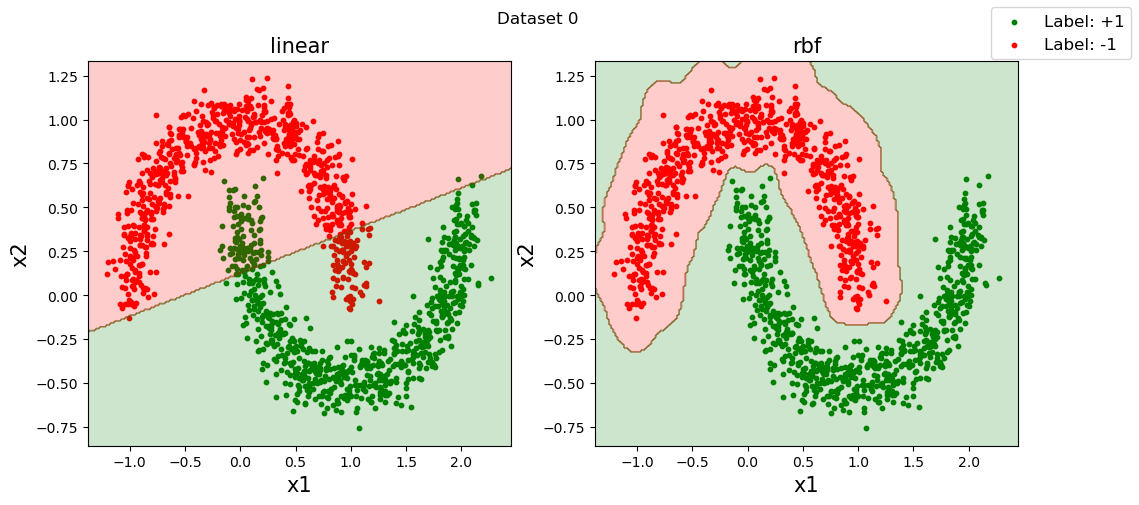

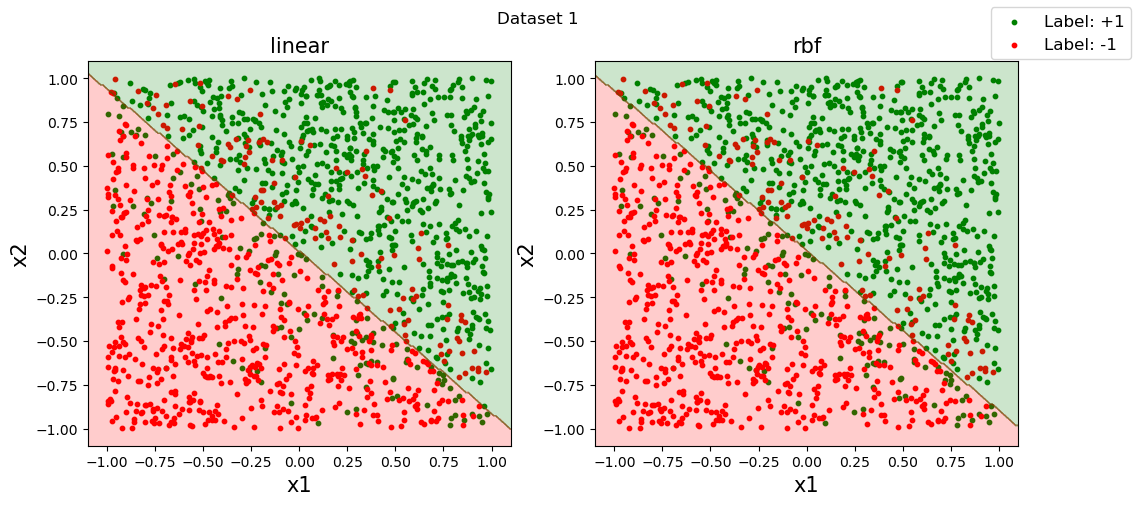

ValueError: X has 2 features, but SVC is expecting 64 features as input.

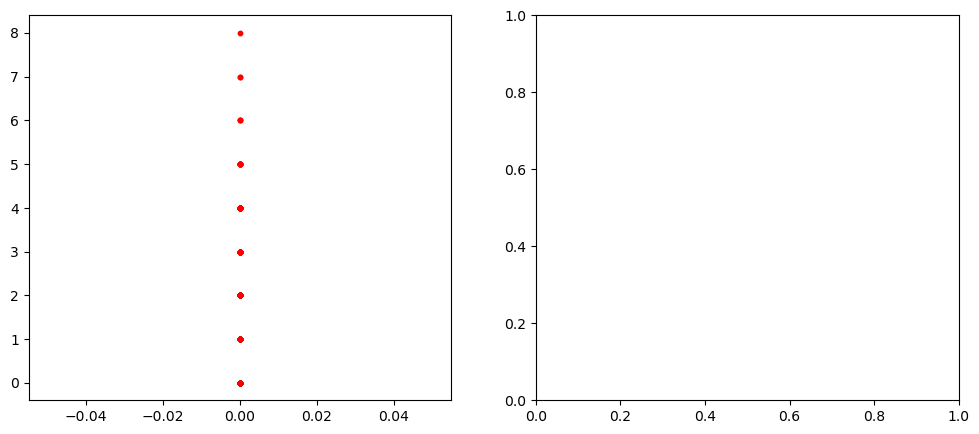

In [7]:
# Codewrite cell: Generate plots of learned classifier for all three kernel types, on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 3 * 2 = 6

datasets = [np.load("Datasets/dataset_A.npz"), np.load("Datasets/dataset_B.npz"), np.load("Datasets/dataset_C.npz"), np.load("Datasets/dataset_D.npz")]
kernels = ['linear', 'rbf']
for i,dataset in enumerate(datasets):
    X_train = dataset['arr_0']
    Y_train = dataset['arr_1']
    X_test = dataset['arr_2']
    Y_test = dataset['arr_3']
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    line = [0, 0]
    for j,kernel in enumerate(kernels):
        reg_param, kernel_param = cross_validate(X_train, Y_train, kernel)
        svm_clf = learn_SVM(X_train, Y_train, kernel, reg_param, kernel_param)
        X_train_plus = X_train[Y_train==1]
        X_train_minus = X_train[Y_train==-1]
        line[0] = ax[j].scatter(X_train_plus[:,0], X_train_plus[:,1], c="green", s=10)
        line[1] = ax[j].scatter(X_train_minus[:,0], X_train_minus[:,1], c="red", s=10)
        x_min, x_max = ax[j].get_xlim()
        y_min, y_max = ax[j].get_ylim()
        X,Y = np.meshgrid(np.linspace(x_min,x_max,200), np.linspace(y_min,y_max,200))
        X_bg = np.transpose(np.array([np.ndarray.flatten(X), np.ndarray.flatten(Y)]))
        Z = svm_clf.predict(X_bg)
        Z = np.reshape(a=Z, newshape=X.shape, order='C')
        ax[j].contourf(X, Y, Z, colors=["red", "green"], alpha=0.2)
        ax[j].set_xlabel("x1", fontsize=15)
        ax[j].set_ylabel("x2", fontsize=15)
        ax[j].set_title(kernel, fontsize=15)
    plt.suptitle("Dataset " + str(i))
    fig.legend(handles=line, labels=["Label: +1", "Label: -1"], fontsize=12)
    plt.show()




# 3. Decision Tree

Write code for learning decision tree below. Take as an argument a hyperparameter on what size node to stop splitting. Use a part of training set as validation set.

Write code for running in the cell after (You may be asked to demonstrate your code during the viva using this cell.)

In text cell after that report the following numbers you get by running appropriate code:

For all four data sets  report the best node size to stop splitting. Report the training and test zero-one error for those hyperparameters.

For datasets A and B, also illustrate the learned classifier. Do this in the last codeWrite cell for this question.

Important: Think about how you will represent a decision tree. (Possible soln: Store as a list of tuples containing node position, attribute to split, threshold, class to classifiy (if leaf node) )


In [ ]:
# CodeWrite cell
# Write Decision tree classifier from scratch, 
# write only functions here (you may write extra functions here if you wish)
def train_decision_tree(X, Y, num_nodes_stop=1, criterion='accuracy'):
    """ Returns a decision tree trained on X and Y. 
    Stops splitting nodes when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Returns a tree (In whatever format that you find appropriate)
    """
    

def eval_decision_tree(tree, test_X):
    """ Takes in a tree, and a bunch of instances X and 
    returns the tree predicted values at those instances."""





In [6]:
# CodeWrite cell
# Write code here for doing validation to find the best hyperparameters (i.e. num_nodes_stop)
# Also Generate the numbers that you report below. 
# Repeat with criterion set to entropy also.



TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  



In [ ]:
## Codewrite cell: Generate plots of learned decision tree classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots only required for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 




# 4 Random Forest classifier

Write code for learning RandomForests below. Fix the following hyper parameters: (Fraction of data to learn tree=0.5, Fraction of number of features chosen in each node=0.5, num_nodes_stop=1).  Choose the number of trees to add in the forest by using a validation set. You may use a slightly modified version of the decision tree code you had written earlier.

Write code for running in the cell after the nest. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  report the best number of trees found. Report the training and test zero-one error for those hyperparameters.

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each kernel setting. Do this in the last codeWrite cell for this question.

In [ ]:
# CodeWrite cell
# Write Random Forest classifier. 
def train_random_forest(X, Y, num_trees=10, num_nodes_stop=1, 
                        criterion='accuracy', a=0.5, b=0.5):
    """ Returns a random forest trained on X and Y. 
    Trains num_trees.
    Stops splitting nodes in each tree when a node has hit a size of "num_nodes_stop" or lower.
    Split criterion can be either 'accuracy' or 'entropy'.
    Fraction of data used per tree = a
    Fraction of features used in each node = b
    Returns a random forest (In whatever format that you find appropriate)
    """
    

def eval_random_forest(random_forest, test_X):
    """ Takes in a  random forest object (hhowever you want to store it), and a bunch of instances X and 
    returns the tree predicted values at those instances."""




In [ ]:
# CodeWrite cell
# Write code for choosing the best hyperparameters (num_trees, num_nodes_stop)
# Write code here for generating the numbers that you report below.
# Repeat above for criterion set to entropy also.



TextWrite cell: Give your observations and the list of hyperparameter choices and train zero-one error  and test zero-one error, for all 4 datasets (2 real world and 2 synthetic).  


In [3]:
## Codewrite cell: Generate plots of learned Random Forest classifier on dataset_A and datasset_B.
# Plots should give both the learned classifier and the train data. 
# Plots required only for the accuracy criterion.
# Similar to  Bishop Figure 4.5 (with just two classes here.)
# Total number of plots = 2 


# 5 AdaBoost

Write code for learning using AdaBoost below. Use 3 different weak learners below. (You may reuse code written above)

1. 1 node decision tree 
2. Decision tree of fixed depth = 3 (Root, child, grand child)
3. Decision tree of fixed depth = 7 (Root, child, grand child, ..., great^4 grand child)

Run for 50 iterations. You may use the accuracy split criterion for all the three weak learners.

Write code for running in the next cell. (You may be asked to demonstrate your code during the viva using this cell.) 

In text cell after that report the following numbers you get by running appropriate code:

For all 4 data sets (A,B,C,D)  plot the train and test accuracy vs iterations. A total of 12 plots is expected. 4 datasets * 3 weak learners. Each plot should contain two curves, train and test error.  

For the synthetic classification datasets (datasets A and B) in 2-dimensions, also illustrate the learned classifier for each weak learner setting. A total of 6 contourf style plots are expected here. Do this in the last codeWrite cell for this question.

Summarise your observations in the last textwrite cell.

In [4]:
# Codewrite cell
# Write code to run here (no plotting)


In [5]:
# Codewrite cell 
# Plots for iteration vs error here


In [6]:
# Codewrite cell 
# Plots for illustrating the classifier here


Textwrite cell: